<a href="https://colab.research.google.com/github/marcelaman777/Bootcamp_Final/blob/main/CLUSTERIZACI%C3%93N_Y_SUS_PRINCIPALES_ALGORITMOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CLUSTERIZACIÓN Y SUS PRINCIPALES ALGORITMOS**

La empresa MarketX te ha contratado como analista de datos para segmentar sus clientes y mejorar sus estrategias de marketing. Cuentas con un conjunto de datos que contiene información sobre el  monto gastado por los clientes y la frecuencia con la que realizan compras. Tu objetivo es agrupar a  los clientes en segmentos utilizando el argoritmo K-Means.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ruta_archivos = '/content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, ward

##**1. Carga de datos**

In [ ]:
df = pd.read_csv(ruta_archivos + 'datos_clientes_kmeans.csv')
print(f'shape: {df.shape}')
df.head()

shape: (100, 3)


,ID_Cliente,Monto_Gastado_USD,Frecuencia_Compra
0,1,599.342831,9
1,2,472.347140,5
2,3,629.537708,1
3,4,804.605971,19
4,5,453.169325,10


In [ ]:
# revisar duplicados
print(f'Cantidad de duplicados: {df.duplicated().sum()}')

# revisar nulos
print(f'Cantidad de nulos: {df.isnull().sum().sum()}')

Cantidad de duplicados: 0
Cantidad de nulos: 0


##**2. Aplicación de K-Means**


In [ ]:
# escalar df

df_scaled = StandardScaler().fit_transform(df.drop('ID_Cliente', axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.columns[1:])
df_scaled.head()

,Monto_Gastado_USD,Frecuencia_Compra
0,0.667618,-0.673174
1,-0.042634,-1.124212
2,0.836489,-1.575250
3,1.815597,0.454421
4,-0.149890,-0.560415


###**Dendrogram**

In [ ]:
# visualizar dendrograma

def graficar_dendrograma(df, metodo='ward'):
    linked = linkage(df, method=metodo)

    plt.figure(figsize=(15, 5))
    dendrogram(linked,
                orientation='top',
                distance_sort='descending',
                show_leaf_counts=False)
    plt.title(f"Dendrograma - Clusterización Jerárquica (método {metodo})", weight='bold')
    plt.xlabel("Observaciones")
    plt.ylabel("Distancia")
    plt.tight_layout()
    plt.show()

Explicación de los distintos métodos utilizados como parámetro "method" en scipy.cluster.hierarchy.linkage:

- single (Algoritmo del Vecino más Cercano): Calcula la distancia entre los dos puntos más cercanos de los clústeres diferentes.
- complete (Algoritmo del Vecino más Lejano): Calcula la distancia entre los dos puntos más lejanos de los clústeres diferentes.
- average (UPGMA): Calcula la distancia promedio entre todos los pares de puntos de los clústeres diferentes.
- weighted (WPGMA): Similar a average, pero pondera las distancias según el tamaño de los clústeres.
- centroid (UPGMC): Calcula la distancia entre los centroides (medias) de los dos clústeres.
- median (WPGMC): Similar a centroid, pero utiliza medianas en lugar de medias.
- ward: Minimiza la varianza de los clústeres que se están fusionando. Tiende a producir clústeres de tamaño aproximadamente igual.

Cada método puede dar como resultado un dendrograma diferente y, por lo tanto, influir en los clústeres resultantes al cortar el dendrograma en un determinado umbral.

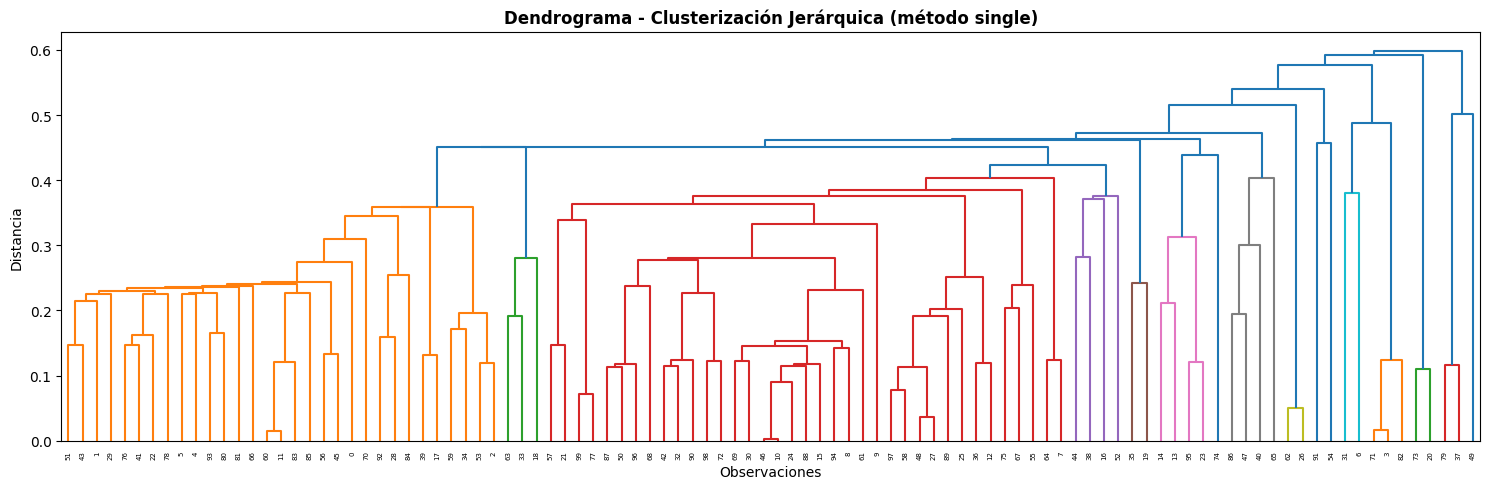

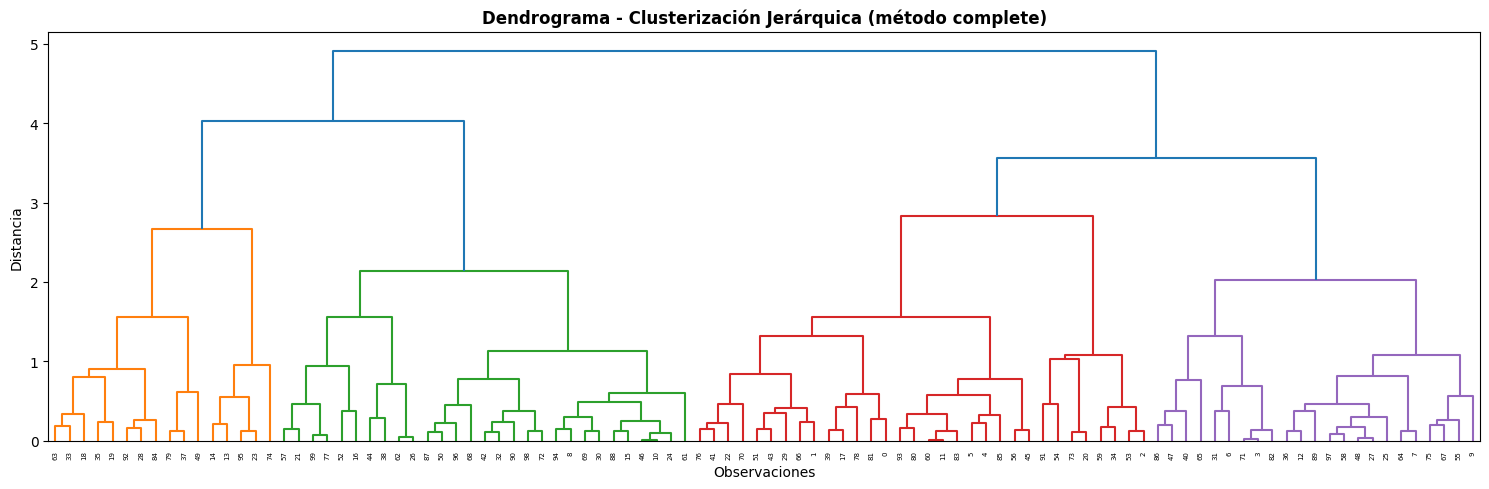

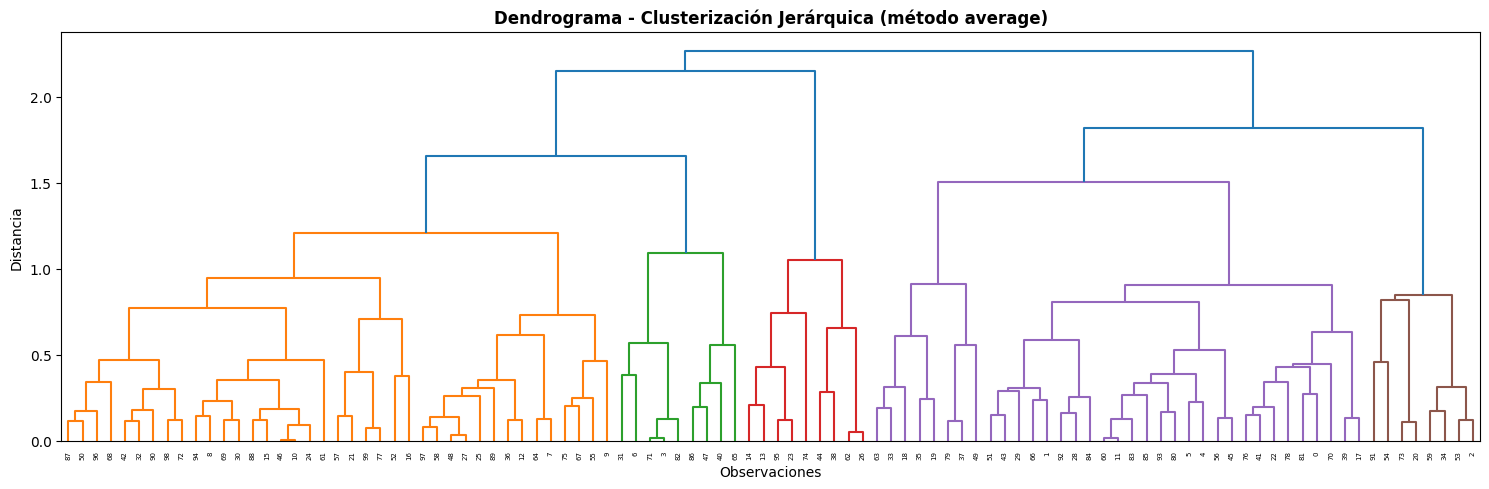

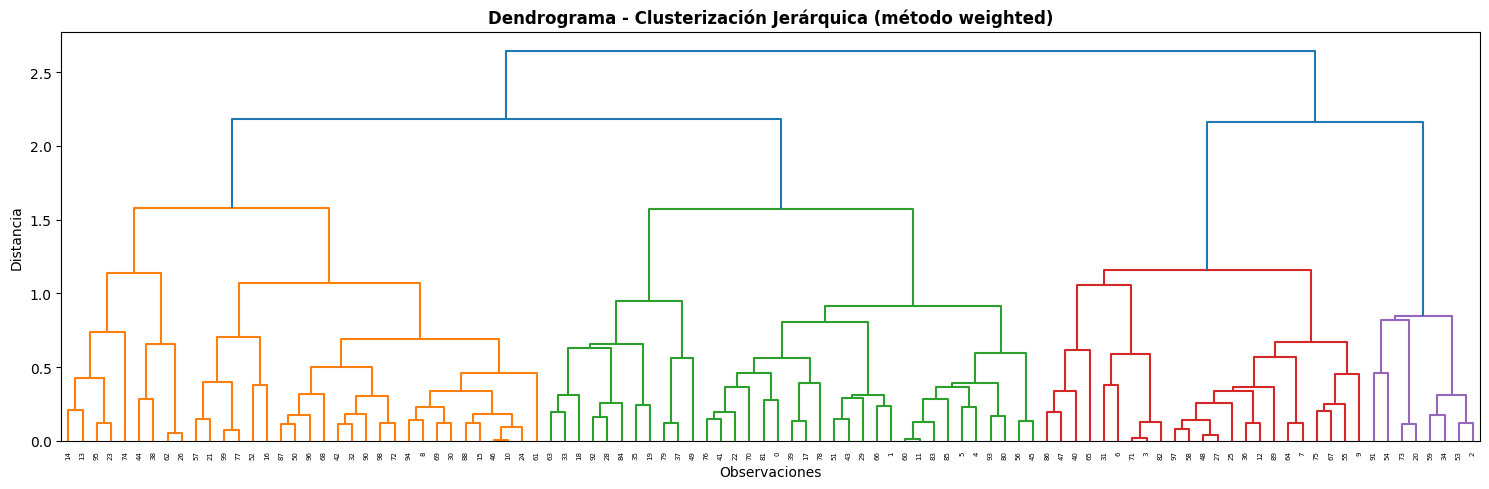

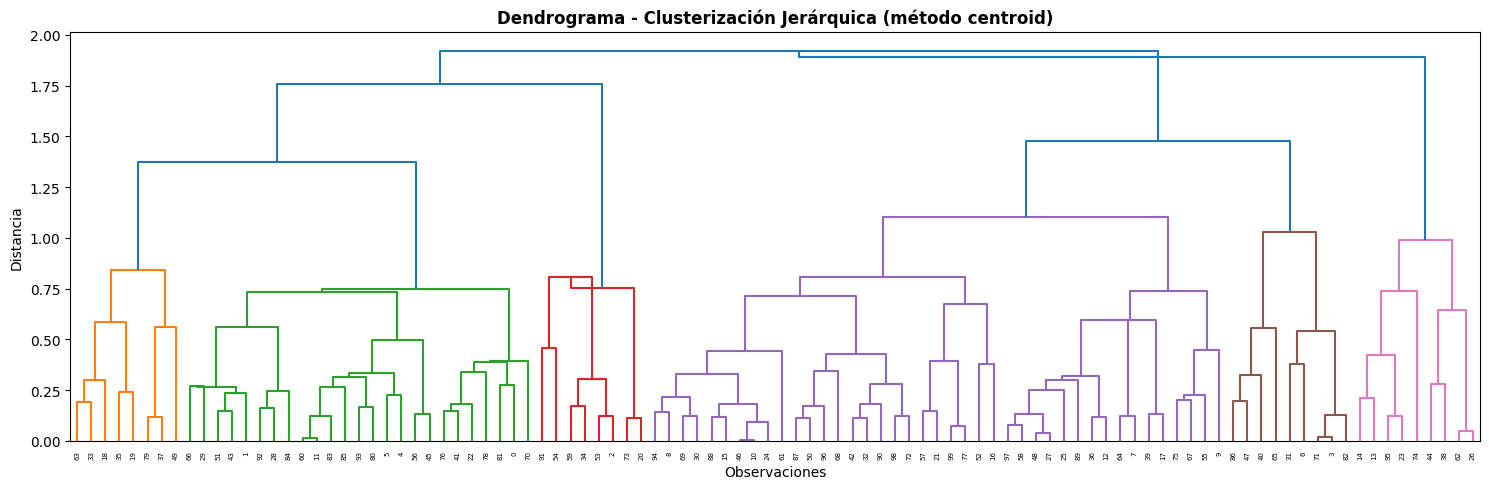

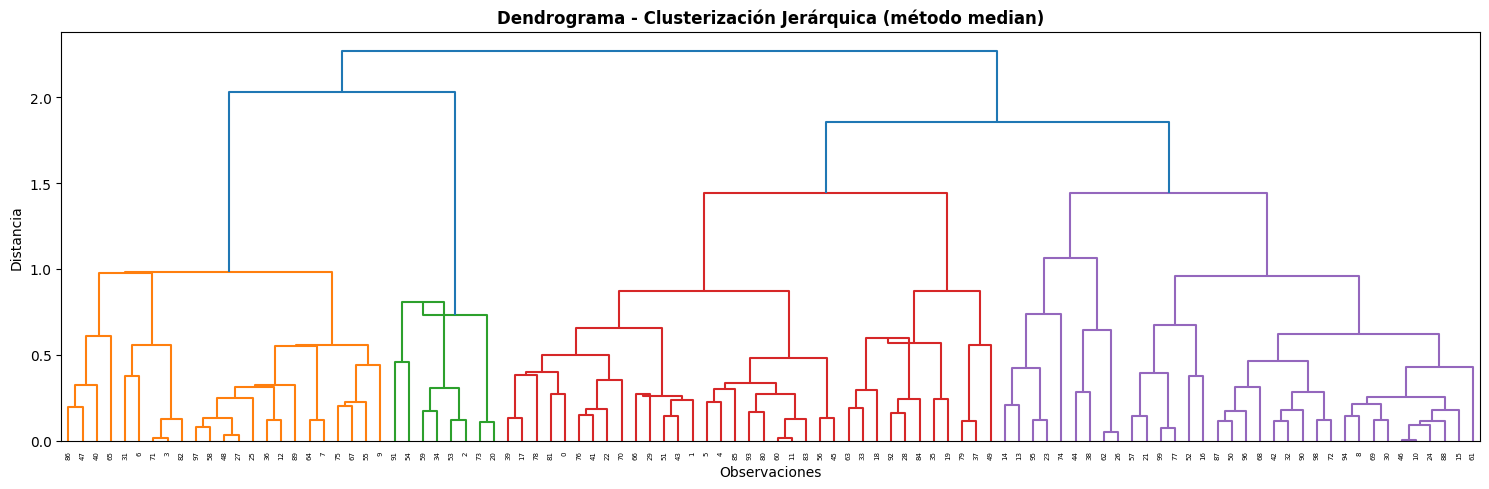

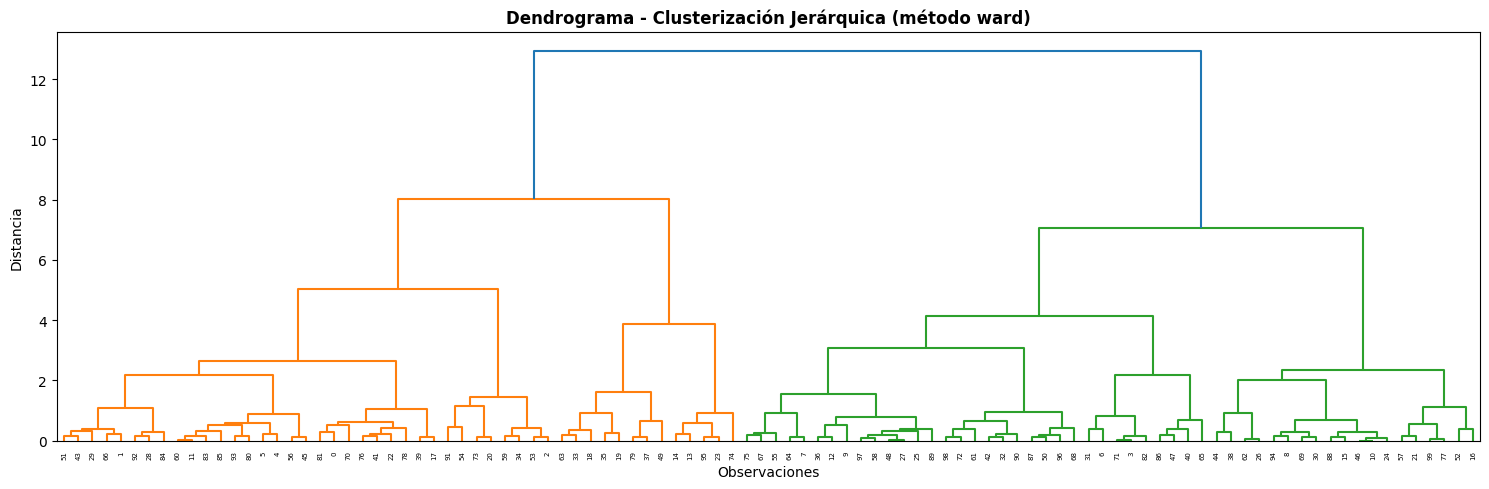

In [ ]:
for metodo in ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']:
    graficar_dendrograma(df_scaled, metodo=metodo)
    print()

Visualmente vemos que hay varios métodos con los cuales es razonable usar 4 clústeres:
- complete,
- average,
- weighted,
- median, y
- ward.

In [ ]:
# determinar el número de clusters para el método de ward

# Generate the linkage matrix using the ward method
linked = linkage(df_scaled, method='ward')

# Set a threshold (you can adjust this value)
threshold = 7

# Use fcluster to get cluster assignments for the given threshold
clusters = fcluster(linked, threshold, criterion='distance')

# Get the number of unique clusters
num_clusters = len(np.unique(clusters))

print(f"For a threshold of {threshold}, there are {num_clusters} clusters.")

# You can also see the cluster assignment for each data point
df['cluster_dendro'] = clusters
df.head()

For a threshold of 7, there are 4 clusters.


,ID_Cliente,Monto_Gastado_USD,Frecuencia_Compra,cluster_dendro
0,1,599.342831,9,4
1,2,472.347140,5,4
2,3,629.537708,1,4
3,4,804.605971,19,2
4,5,453.169325,10,4


In [ ]:
def graficar_clusters(df, cluster, texto):
    plt.figure(figsize=(8, 6))

    palette = 'tab10'
    ax = sns.scatterplot(data=df, x='Monto_Gastado_USD', y='Frecuencia_Compra', hue=cluster, palette=palette, s=50)
    ax.set_title("Clusterización con "+ texto, weight='bold')
    ax.set_xlabel("Monto Gastado (USD)")
    ax.set_ylabel("Frecuencia de Compra")
    plt.legend(title='Cluster:', loc='best')
    plt.tight_layout()
    plt.show()

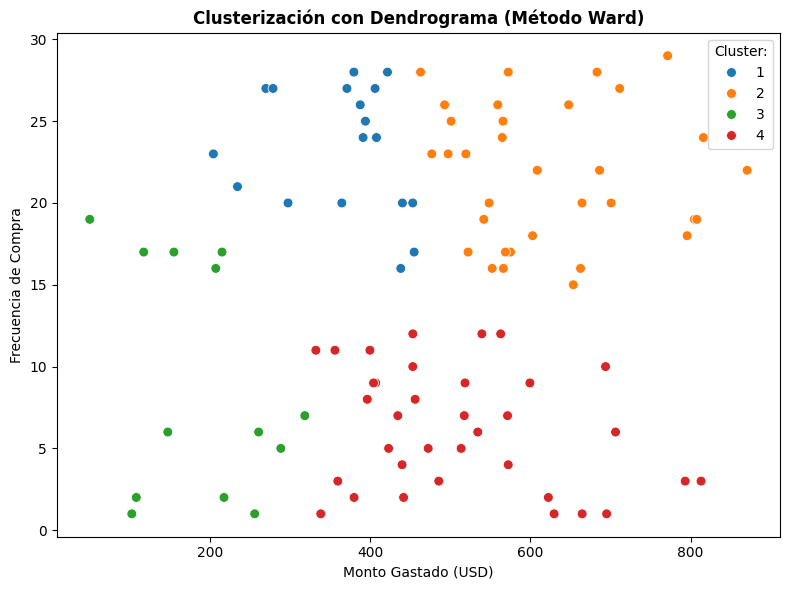

In [ ]:
graficar_clusters(df, 'cluster_dendro', texto='Dendrograma (Método Ward)')

Los clústeres no permiten una segmentación fácil de los clientes según monto gastado y frecuencia de compra.

###**K-means**

**Método del codo para determinar el número de grupos**

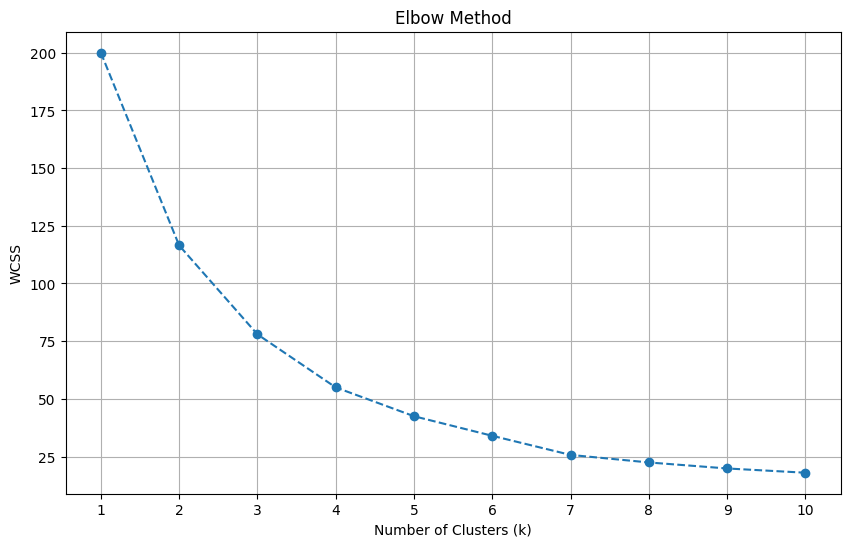

In [ ]:
# Calculate WCSS for a range of cluster numbers (WCSS: within cluster sum os squares)
wcss = []
for i in range(1, 11): # Test k from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

# Plot the WCSS values
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

No ve ve un quiebre claro en el gráfico del codo. Seguiré con 4 clústeres como elección.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(df_scaled)
df.head()

,ID_Cliente,Monto_Gastado_USD,Frecuencia_Compra,cluster_dendro,cluster_kmeans
0,1,599.342831,9,4,2
1,2,472.347140,5,4,1
2,3,629.537708,1,4,2
3,4,804.605971,19,2,0
4,5,453.169325,10,4,1


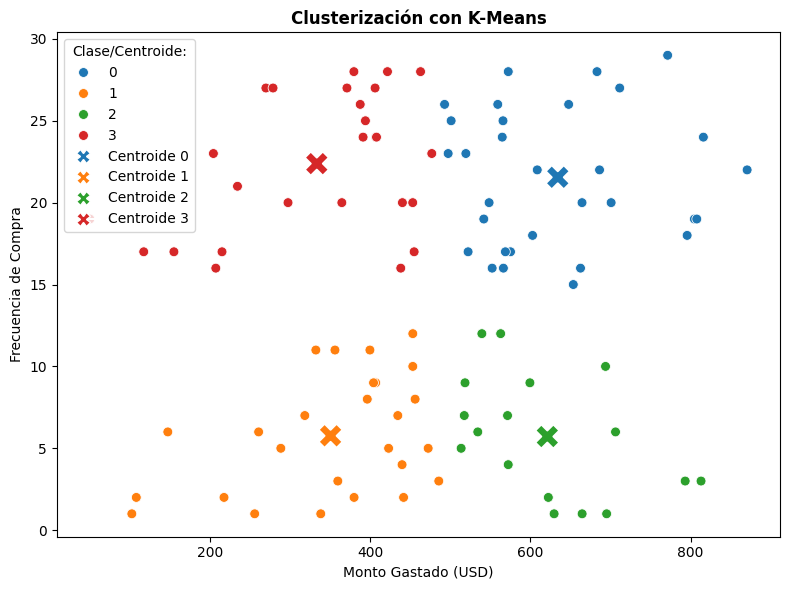

In [ ]:
plt.figure(figsize=(8, 6))

palette = sns.color_palette('tab10', n_colors=kmeans.n_clusters)
ax = sns.scatterplot(data=df, x='Monto_Gastado_USD', y='Frecuencia_Compra', hue='cluster_kmeans', palette=palette, s=50)

# Get centroid coordinates
centroid_x = kmeans.cluster_centers_[:, 0] * df['Monto_Gastado_USD'].std() + df['Monto_Gastado_USD'].mean()
centroid_y = kmeans.cluster_centers_[:, 1] * df['Frecuencia_Compra'].std() + df['Frecuencia_Compra'].mean()

# Create a list of colors for the centroids based on their cluster labels
centroid_colors = [palette[label] for label in range(kmeans.n_clusters)]

# Plot centroids with correct colors
sns.scatterplot(x=centroid_x, y=centroid_y, s=300, c=centroid_colors, marker='X', ax=ax)

ax.set_title("Clusterización con K-Means", weight='bold')
ax.set_xlabel("Monto Gastado (USD)")
ax.set_ylabel("Frecuencia de Compra")

legend_handles = [
    Line2D([0], [0], marker='X', color='w', label=f'Centroide {i}',
           markerfacecolor=centroid_colors[i], markersize=10) for i in range(kmeans.n_clusters)
]

# Get existing legend handles and labels for the clusters
handles, labels = ax.get_legend_handles_labels()

# Combine existing and custom legend handles
all_handles = handles + legend_handles

# Set the legend
plt.legend(handles=all_handles, title='Clase/Centroide:', loc='best')

plt.tight_layout()
plt.show()

Los clústeres generados permiten una segmentación fácil de los clientes según monto gastado y frecuencia de compra en cuadrantes.

Probemos usar el silhouette score.

El coeficiente de silueta es una métrica que se utiliza para evaluar la calidad de los clústeres creados por un algoritmo de clusterización como K-Means. Mide cuán similar es un objeto a su propio clúster en comparación con otros clústeres.

El coeficiente de silueta para un único punto de datos se calcula utilizando dos valores:

1. a: La distancia media entre ese punto de datos y todos los demás puntos en el mismo clúster.
2. b: La distancia media entre ese punto de datos y todos los puntos en el clúster vecino más cercano.

El coeficiente de silueta para un punto de datos se calcula entonces como (b - a) / max(a, b).

El coeficiente de silueta general para un conjunto de clústeres es el coeficiente de silueta promedio de todos los puntos de datos.

Esto es lo que indican los valores del coeficiente de silueta:

- Puntuaciones cercanas a +1: El punto de datos está bien agrupado y está lejos de los clústeres vecinos.
- Puntuaciones cercanas a 0: El punto de datos está cerca del límite de decisión entre dos clústeres vecinos.
- Puntuaciones cercanas a -1: El punto de datos puede haber sido asignado al clúster incorrecto.

Una puntuación de silueta promedio más alta generalmente indica una mejor clusterización.

In [ ]:
# Calculate the silhouette score for the KMeans clustering
silhouette_avg = silhouette_score(df_scaled, df['cluster_kmeans'])

print(f"El coeficiente de silueta para la clusterización K-Means es: {silhouette_avg}")

El coeficiente de silueta para la clusterización K-Means es: 0.3775096735499604


En este caso, un valor de 0.3775 sugiere que los clústeres están algo separados, pero hay cierta ambigüedad o solapamiento entre ellos. Podría ser útil explorar si un número diferente de clústeres mejora esta puntuación, o si otros algoritmos de clustering podrían ofrecer una mejor separación.

Sin embargo, para los propósitos de la tarea y dado que el método del codo no fue concluyente, 4 clústeres es una elección razonable para proceder con el análisis y las estrategias de marketing.

###**Agglomerative Clustering**

In [ ]:
agglo = AgglomerativeClustering(n_clusters=4)
df['cluster_agglo'] = agglo.fit_predict(df_scaled)
df.head()

,ID_Cliente,Monto_Gastado_USD,Frecuencia_Compra,cluster_dendro,cluster_kmeans,cluster_agglo
0,1,599.342831,9,4,2,0
1,2,472.347140,5,4,1,0
2,3,629.537708,1,4,2,0
3,4,804.605971,19,2,0,1
4,5,453.169325,10,4,1,0


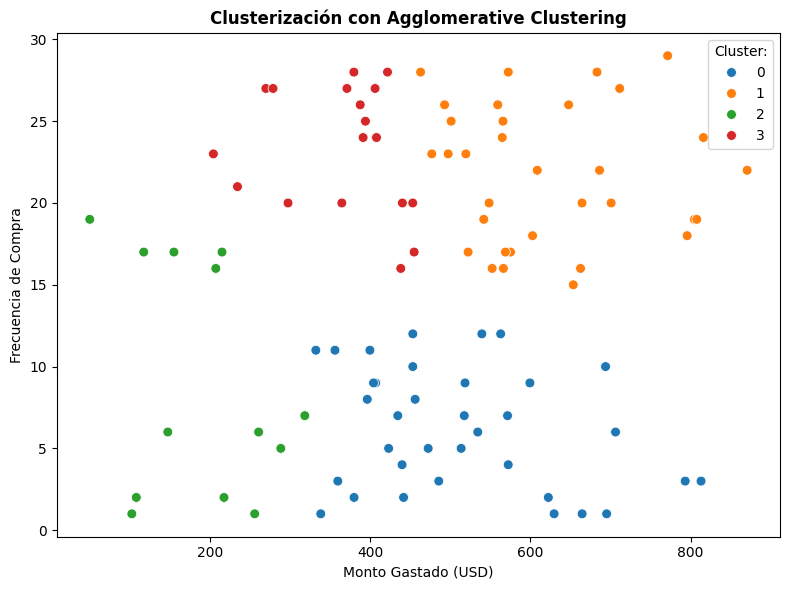

In [ ]:
graficar_clusters(df, 'cluster_agglo', texto='Agglomerative Clustering')

Los clústeres no permiten una segmentación fácil de los clientes según monto gastado y frecuencia de compra.

In [ ]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(df_scaled, df['cluster_agglo'])

print(f"El coeficiente de silueta para la clusterización Aglomerativa es: {silhouette_avg}")

El coeficiente de silueta para la clusterización Aglomerativa es: 0.36099403236630545


El resultado del silhouette score es apenas más bajo que el de K-Means.

###**DBS**

**Análisis de la gráfica de k-distancia para determinar valor de eps:**

Puedes calcular la distancia al k-ésimo vecino más cercano para cada punto de datos y luego trazar estas distancias en orden ascendente. Un "codo" o cambio abrupto en la pendiente de esta gráfica puede sugerir un valor apropiado para eps. La elección de k para este gráfico puede estar relacionada con min_samples.

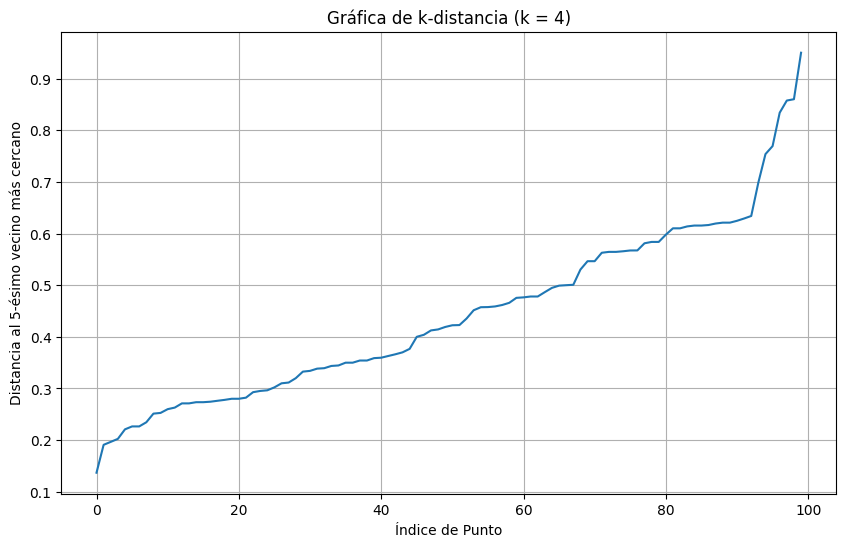

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Assuming min_samples = 5 (a common starting point for DBSCAN)
min_samples = 5

# Calculate the distance to the (min_samples)-th nearest neighbor for each point
neigh = NearestNeighbors(n_neighbors=min_samples)
neigh.fit(df_scaled)
distances, indices = neigh.kneighbors(df_scaled)

# Sort the distances in ascending order
distances = np.sort(distances[:, min_samples-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'Gráfica de k-distancia (k = {min_samples-1})')
plt.xlabel('Índice de Punto')
plt.ylabel(f'Distancia al {min_samples}-ésimo vecino más cercano')
plt.grid(True)
plt.show()

Observando la gráfica, parece haber un cambio notable alrededor de una distancia de 0.6 a 0.7, por lo que hay que probar con eps dentro de ese rango.

In [ ]:
dbscan = DBSCAN(eps=0.6, min_samples=5)
df['cluster_dbscan'] = dbscan.fit_predict(df_scaled)
df.head()

In [ ]:
df.cluster_dbscan.value_counts()

In [ ]:
graficar_clusters(df, 'cluster_dbscan', texto='DBSCAN')

In [ ]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(df_scaled, df['cluster_dbscan'])

print(f"El coeficiente de silueta para la clusterización DBScan es: {silhouette_avg}")

- El coeficiente de silueta es bajo.
- Hay un clúster muy grande (90 puntos), otro muy pequeño (7 puntos) y unos pocos outliers. Esto sugiere que los parámetros actuales (eps=0.6, min_samples=5) podrían no ser los más adecuados para la estructura de densidad de los datos.

Buscaremos una combinación de eps y min_samples que obtengan el mejor coeficiente de silueta.

In [ ]:
# Define ranges for eps and min_samples to test
eps_range = np.arange(0.1, 1.0, 0.1)  # Test eps from 0.1 to 0.9 with step 0.1
min_samples_range = range(2, 11)      # Test min_samples from 2 to 10

best_score = -1
best_eps = None
best_min_samples = None

results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(df_scaled)

        # Calculate silhouette score only if there is more than 1 cluster and not all points are noise
        if len(np.unique(clusters)) > 1 and -1 in np.unique(clusters) and len(np.unique(clusters)) > 2:
             # Exclude noise points (-1) when calculating silhouette score
            score = silhouette_score(df_scaled[clusters != -1], clusters[clusters != -1])
        elif len(np.unique(clusters)) > 1 and -1 not in np.unique(clusters):
            score = silhouette_score(df_scaled, clusters)
        else:
            score = -1 # Assign a low score if clustering is not valid for silhouette

        results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': score})

        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples

print("Resultados de la búsqueda de parámetros:")
for res in results:
    print(f"eps: {res['eps']:.1f}, min_samples: {res['min_samples']}, silhouette_score: {res['silhouette_score']:.4f}")

print(f"\nMejores parámetros encontrados: eps = {best_eps:.1f}, min_samples = {best_min_samples} con un coeficiente de silueta de {best_score:.4f}")

In [ ]:
dbscan_2 = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df['cluster_dbscan_optimo'] = dbscan_2.fit_predict(df_scaled)
df.cluster_dbscan_optimo.value_counts()

Es interesante observar que, a pesar de obtener un coeficiente de silueta alto con eps = 0.2 y min_samples = 4, DBSCAN aún identifica una gran cantidad de outliers y solo dos clústeres pequeños.

Esto resalta una característica importante de DBSCAN: está diseñado para encontrar regiones densas de puntos y marcar como outliers aquellos puntos que no pertenecen a ninguna región densa.

El hecho de que obtengamos 86 outliers y solo dos clústeres pequeños (de 9 y 5 puntos) con estos parámetros sugiere que, a este nivel de densidad (min_samples = 4) y con este radio (eps = 0.2), solo hay un par de grupos muy pequeños de puntos que cumplen los criterios para formar un clúster denso. El resto de los puntos no tienen suficientes vecinos cercanos dentro del radio especificado y, por lo tanto, son clasificados como ruido (outliers).

Aunque el coeficiente de silueta para los puntos que sí formaron clústeres es alto (indicando que esos pocos puntos están bien separados de los otros puntos en los clústeres), no evalúa la calidad de la asignación de los outliers.

En este escenario, donde la mayoría de los puntos son considerados outliers por DBSCAN, este algoritmo podría no ser el más adecuado para segmentar a todos los clientes en grupos distintos. Los métodos probados anteriormente, como K-Means o Agglomerative Clustering (que sí asignan cada punto a un clúster), podrían ser más apropiados para la tarea de segmentación de todos los clientes si el objetivo es tener a cada cliente asignado a un grupo de marketing.

###**Gaussian Mixture**

Existen varios métodos para determinar el número óptimo de componentes (análogo al número de clústeres) en Gaussian Mixture Models (GMM). A diferencia del método del codo para K-Means, estos métodos para GMM se basan en criterios de información que evalúan qué tan bien el modelo se ajusta a los datos mientras penalizan la complejidad (un mayor número de componentes).

Los dos criterios más comunes son:

- Criterio de Información de Akaike (AIC): El AIC estima la calidad relativa de los modelos estadísticos para un conjunto de datos dado. Un valor de AIC más bajo generalmente indica un mejor modelo. Tiende a favorecer modelos más complejos que el BIC.
- Criterio de Información Bayesiano (BIC): El BIC es similar al AIC pero impone una penalización más fuerte por el número de parámetros (y por lo tanto, el número de componentes). Un valor de BIC más bajo también indica un mejor modelo. El BIC tiende a favorecer modelos más simples que el AIC.

Para usar estos métodos, ajustarías GMM con un rango de diferentes números de componentes y luego calcularías el AIC y el BIC para cada modelo. Trazarías estos valores y buscarías el número de componentes que minimiza el AIC o el BIC.

In [ ]:
# Define a range for the number of components to test
n_components_range = range(1, 11)  # Test from 1 to 10 components

bic = []
aic = [] # Also calculate AIC for comparison

for n_components in n_components_range:
    # Create a GMM instance with the current number of components
    gm = GaussianMixture(n_components=n_components, random_state=42)

    # Fit the GMM to the scaled data
    gm.fit(df_scaled)

    # Calculate and store the BIC and AIC
    bic.append(gm.bic(df_scaled))
    aic.append(gm.aic(df_scaled))

# Plot the BIC and AIC values
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic, marker='o', linestyle='--', label='BIC')
plt.plot(n_components_range, aic, marker='o', linestyle='-', label='AIC')
plt.title('BIC and AIC for Gaussian Mixture Models')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion Value')
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

# Find the number of components that minimizes the BIC
optimal_n_components_bic = n_components_range[np.argmin(bic)]
optimal_n_components_aic = n_components_range[np.argmin(aic)]

print(f"Número óptimo de componentes según BIC: {optimal_n_components_bic}")
print(f"Número óptimo de componentes según AIC: {optimal_n_components_aic}")

In [ ]:
# con 2 componentes
gm_2 = GaussianMixture(n_components=2, random_state=42)
df['cluster_gm_2'] = gm_2.fit_predict(df_scaled)
df.head()

In [ ]:
graficar_clusters(df, 'cluster_gm_2', texto='Gaussian Mixture con 2 Componentes')

Para 2 componentes la separación es simple y solo tiene relación con la frecuencia de compra.

In [ ]:
gm_3 = GaussianMixture(n_components=3, random_state=42)
df['cluster_gm_3'] = gm_3.fit_predict(df_scaled)
df.head()

In [ ]:
graficar_clusters(df, 'cluster_gm_3', texto='Gaussian Mixture con 3 Componentes')

Los clústeres no permiten una segmentación fácil de los clientes según monto gastado y frecuencia de compra.

##**3. Análisis de resultados**

Vamos a analizar las características promedio de cada uno de los 4 clústeres identificados por K-Means. Esto nos ayudará a entender el perfil de cliente de cada grupo.

In [ ]:
graficar_clusters(df, 'cluster_kmeans', texto='K-Means')

In [ ]:
estadisticas = df.groupby('cluster_kmeans').agg({
    'Monto_Gastado_USD': 'mean',
    'Frecuencia_Compra': 'mean'
})
estadisticas

- Clúster 0: Altos en Monto Gastado y altos en Frecuencia de Compra. Estos son los clientes más valiosos y leales.
    - Estrategias de Marketing: Programas de fidelización exclusivos, ofertas premium, comunicación personalizada y anticipada sobre nuevos productos o servicios, solicitar feedback para mejorar la experiencia de cliente.
- Clúster 1: Bajos en Monto Gastado y bajos en Frecuencia de Compra. Estos podrían ser nuevos clientes o clientes de bajo valor.
    - Estrategias de Marketing: Campañas de reactivación (si son antiguos), ofertas de introducción, comunicación enfocada en el valor y los beneficios, educación sobre la gama de productos/servicios.
- Clúster 2: Altos en Monto Gastado pero bajos en Frecuencia de Compra. Estos son clientes que gastan mucho pero no compran a menudo, quizás compradores ocasionales de artículos de alto valor.
    - Estrategias de Marketing: Incentivar la repetición de compra con descuentos por volumen o programas de recompensa, recordarles la marca y sus beneficios periódicamente, ofrecer recomendaciones personalizadas basadas en sus compras pasadas.
- Clúster 3: Bajos en Monto Gastado pero altos en Frecuencia de Compra. Estos son clientes que compran a menudo pero gastan poco, quizás compradores frecuentes de artículos de bajo costo.
    - Estrategias de Marketing: Fomentar la compra de artículos de mayor valor con bundles o promociones, programas de puntos por cada compra, comunicación que resalte productos complementarios a sus compras habituales.